<h1>BrainStorm[ing] Work</h1>

This notebook contains code for testing out concepts, from data pulling and normalizatino to building baselines models. The final results of things tested in this notebook will be contained in .py files

In [39]:
import numpy as np
import torch
from torch.utils.data import Dataset
import yfinance as yf
import os
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from importlib import reload
import utils
pd.set_option('display.max_columns', None)

<h2>Data</h2>

Data pulled will be 2756 stocks from the NYSE exchange, from 2007-01-01 to 2021-12-31 (15 years of data). Final pool will be 2718 stocks.
&nbsp;
&nbsp;
<h3>Get Tickers List</h3>
<p>
For this new method we will download all the tickers available in the NYSE via the NASDAQ website, which offers a screener for NYSE stocks. This gives us a list of NYSE stocks and their current price and information, from which we can extract the results. At the time of this writing <b>3180</b> stocks were returned by the screener
</p>

In [63]:
data_path = "nasdaq_screener_1646792889970.csv"
api_key = 'dbb9d20d6afbdb0075d1d9d9d492c6bb'

df = pd.read_csv(data_path)
symbols_list = df["Symbol"].tolist()

<h3>Data Pulling</h3>

In [62]:
r#create

new shit is working
good


,open,high,low,close,volume,change,changePercent,uOpen,uClose,uHigh,uLow,uVolume,fullOpen,fullClose,fullHigh,fullLow,fullVolume
date,,,,,,,,,,,,,,,,,
2012-05-18,43.00,45.00,38.000,39.5828,593507942,0.000000,0.0000,44.00,39.8028,46.00,39.000,604823580,43.00,39.2235,47.00,39.00,596502768
2012-05-21,37.61,37.81,33.000,35.2000,170218597,-4.268244,-0.1118,37.08,34.4200,36.94,33.000,172820253,37.97,35.0100,37.23,34.00,175913329
2012-05-22,33.47,34.74,31.060,32.0000,105267545,-3.142458,-0.0930,32.84,31.0000,34.50,31.640,103427207,32.81,32.0000,34.25,31.35,106267034
2012-05-23,32.10,33.10,32.100,33.0000,75817640,1.000000,0.0330,32.53,33.0000,33.30,31.930,74841427,32.05,33.0000,33.50,31.85,74082797
2012-05-24,33.44,34.51,32.030,34.5100,50279282,1.050986,0.0329,34.07,33.0900,34.08,32.540,51120662,34.42,33.3200,33.62,33.26,52279322
2012-05-25,33.92,34.11,31.910,32.6800,37196339,-1.127757,-0.0352,33.97,33.4100,33.53,31.670,38068782,34.08,33.1200,32.98,32.17,38402572
2012-05-29,32.27,32.97,28.650,29.1800,80361912,-3.132592,-0.0984,32.11,29.4000,32.72,29.750,78559140,31.71,29.0100,33.04,29.87,81900387
2012-05-30,30.10,30.55,28.510,29.2300,57456957,-0.655904,-0.0228,28.90,29.4800,30.07,28.320,57346026,30.00,29.5600,30.41,28.59,59119628
2012-05-31,29.93,30.53,27.370,29.8000,115521783,1.451724,0.0500,29.05,30.6000,30.05,27.170,117148679,28.97,30.9000,30.68,27.74,112158056


In [56]:
df_fb.tail()

,open,high,low,close,volume,change,changePercent
date,,,,,,,
2022-03-04,212.06,212.06,201.360,209.02,209.02,209.02,209.02
2022-03-07,206.33,206.33,194.280,196.79,196.79,196.79,196.79
2022-03-08,192.18,205.20,192.180,197.37,197.37,197.37,197.37
2022-03-09,202.62,202.62,200.200,200.20,200.20,200.20,200.20
2022-03-10,200.57,203.69,191.384,199.38,199.38,199.38,199.38


In [91]:
data_dict = {}
os.chdir('/home/kagema/Documents/CSC 492/csc492_deep_learning_project')
nasdaq_directory = '/home/kagema/Documents/CSC 492/csc492_deep_learning_project/Data/nasdaq_15yr_data'
nyse_directory = '/home/kagema/Documents/CSC 492/csc492_deep_learning_project/Data/nyse_15yr_data'
print(os.getcwd())
'''
for filename in os.listdir(nasdaq_directory):
    if filename == '.ipynb_checkpoints':
        continue
    ticker_symbol = filename.split('.')[0]
    fullpath = nasdaq_directory + '/' + filename
    data_dict[ticker_symbol] = pd.read_csv(fullpath)
'''
for filename in os.listdir(nyse_directory):
    if filename == '.ipynb_checkpoints':
        continue
    ticker_symbol = filename.split('.')[0]

    fullpath = nyse_directory + '/' + filename
    data_dict[ticker_symbol] = pd.read_csv(fullpath)
    #tickers_list.append(ticker)


/home/kagema/Documents/CSC 492/csc492_deep_learning_project


In [96]:
temp_df_path = '/home/kagema/Documents/CSC 492/csc492_deep_learning_project/Data/nyse_15yr_data/BRCC.csv'
temp_df = pd.read_csv(temp_df_path)

In [97]:
temp_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ticker


<h3>Data Cleaning</h3>

In [92]:
ticker_list = data_dict.keys()
ticker_no_volume_days = []
for ticker in ticker_list:
    df = data_dict[ticker].copy(deep=True)
    df.fillna(method='ffill', inplace=True)
    #drop if front has no values
    df.dropna(inplace=True, how='any')
    data_dict[ticker] = df.copy(deep=True)



<h2>Data Exploration</h2>

Here are the descriptive statistics that we will consider;
- What is the average returns of all stocks in the dataset
- What is the stock with the highest returns
- What is the stock with the lowest returns
- What year did each stock list on the relevant exchange
- What stocks had the highest average VWAP (Volume Weighted Average Price)? (more weight on price with high volume)
    (how does filtering with VWAP help'



In [97]:
#for each stock, year did it list in
error_list = []
from collections import defaultdict
year_dict = defaultdict(int)
for ticker in ticker_list:
    #get the first year stock
    #get the first year stockyear
    try:
        year = int(data_dict[ticker].Date[0].split('-')[0])
        year_dict[year] += 1
    except:
        error_list.append(ticker)
print(error_list)



['EVE', 'ECCV', 'BRD', 'MTVC', 'SFB', 'RRAC', 'SHAP', 'HTAQ', 'STET', 'TCOA', 'RJAC', 'ATEK', 'RCFA', 'SHEL', 'ACDI', 'EAI', 'PORT', 'BFAC', 'MBSC', 'WEL', 'SCUA', 'DMA', 'GBLL', 'BWNB', 'IFIN', 'NETC', 'CNDB', 'APCA', 'DOUG', 'SEDA', 'TRAQ', 'EMP', 'APN', 'PACI', 'MDV', 'BRCC', 'RMMZ', 'JUN', 'NPFD', 'ECCX', 'BIPI', 'ZGN', 'RCA', 'PAXS', 'IRRX', 'NFNT', 'MNTN', 'SUAC', 'IOT']


Pull the data again without the stocks that were giving the errors, which were giving the errors because they were listed in the new york stock exchange after 2022

In [103]:
new_data_dict = {}
for stock in data_dict.keys():
    if stock not in error_list:
        new_data_dict[stock] = data_dict[stock]
    else:
        print(stock)

data_dict = new_data_dict

In [105]:
data_dict['EVE'],head()

KeyError: 'EVE'

In [104]:
error_list

['EVE',
 'ECCV',
 'BRD',
 'MTVC',
 'SFB',
 'RRAC',
 'SHAP',
 'HTAQ',
 'STET',
 'TCOA',
 'RJAC',
 'ATEK',
 'RCFA',
 'SHEL',
 'ACDI',
 'EAI',
 'PORT',
 'BFAC',
 'MBSC',
 'WEL',
 'SCUA',
 'DMA',
 'GBLL',
 'BWNB',
 'IFIN',
 'NETC',
 'CNDB',
 'APCA',
 'DOUG',
 'SEDA',
 'TRAQ',
 'EMP',
 'APN',
 'PACI',
 'MDV',
 'BRCC',
 'RMMZ',
 'JUN',
 'NPFD',
 'ECCX',
 'BIPI',
 'ZGN',
 'RCA',
 'PAXS',
 'IRRX',
 'NFNT',
 'MNTN',
 'SUAC',
 'IOT']

In [76]:
temp_df = data_dict["TFSA"]
temp_df = temp_df[["Date", "Open", "High", "Low", "Close", "Volume"]]
#temp_df[["Date"]].head(30)
temp_df.head(30)

,Date,Open,High,Low,Close,Volume
1,2021-02-12,24.850000,24.900000,24.799999,24.850000,25700
2,2021-02-16,25.250000,25.250000,24.775000,24.820000,46200
3,2021-02-17,24.900000,24.900000,23.700001,24.799999,23400
4,2021-02-18,24.780001,24.900000,24.750000,24.889999,28000
5,2021-02-19,24.799999,24.889999,24.799999,24.860001,16800
6,2021-02-22,24.870001,24.900000,24.792000,24.850000,24200
7,2021-02-23,24.860001,24.950001,24.700001,24.860001,19600
8,2021-02-24,24.969999,25.129999,24.795000,25.129999,26200
9,2021-02-25,25.200001,25.250000,25.150000,25.230000,10700
10,2021-02-26,25.250000,25.299999,24.719999,25.139999,25600


In [73]:
list(data_dict.keys())[0:3]

['THO', 'STAG', 'TFSA']

In [6]:
#graph year list
year_keys = np.sort(list(year_dict.keys()))
new_year_keys = [str(x) if x != 2007 else '<= 2007' for x in year_keys ]
new_year_keys


['<= 2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021']

ConversionError: Failed to convert value(s) to axis units: ['<= 2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

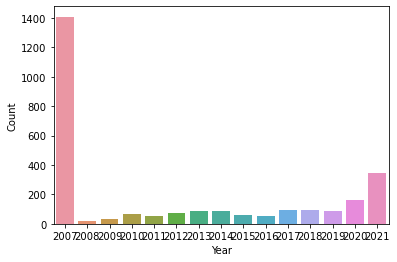

In [14]:
import seaborn as sns
plotting_df = pd.DataFrame(list(year_dict.items()))
plotting_df.columns = ["Year", "Count"]
plotting_df.sort_values(ascending=True, by=['Year'], inplace=True)
#plt.figure(figsize=(20,20))
ax = sns.barplot(x='Year', y='Count', data=plotting_df)
ax.set(xticks=new_year_keys)
plt.show()

In [15]:
print(error_list)

['EVE', 'ECCV', 'BRD', 'MTVC', 'SFB', 'SHAP', 'HTAQ', 'STET', 'TCOA', 'RJAC', 'ATEK', 'RCFA', 'SHEL', 'ACDI', 'EAI', 'PORT', 'BFAC', 'WEL', 'SCUA', 'DMA', 'GBLL', 'IFIN', 'NETC', 'APCA', 'DOUG', 'EMP', 'PACI', 'MDV', 'BRCC', 'RMMZ', 'ECCX', 'BIPI', 'RCA', 'PAXS', 'IRRX', 'NFNT', 'MNTN', 'SUAC']


In [94]:
txt_file = open("missing_tickers.txt", "w")
for ticker in error_list:
    txt_file.write(ticker + '\n')
txt_file.close()

<h2>Data Make Supervised, Split, and Train</h2>

<h3>Method 1: Previous Price</h3>

In [106]:
#from Baselines import train_previous_price
#from Baselines import train_linear
import Baselines

In [107]:
from importlib import reload
reload(Baselines)


m1_mse, m1_rmse, m1_mape = Baselines.train_previous_price(data_dict)
print(f'For the previous price method, the average mse is {m1_mse}, the average rmse is {m1_rmse}, and the average mape is {m1_mape}')

Ticker BEPI caused problem: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.
For the previous price method, the average mse is 70112.71038019816, the average rmse is 8.663542113587901, and the average mape is 0.0613588215261758


<h3>Method 2: Linear Regression</h2>

In [108]:
reload(Baselines)
m2_mse, m2_rmse, m2_mape = Baselines.train_linear(data_dict)
print(f'For the previous price method, the average mse is {m2_mse}, the average rmse is {m2_rmse}, and the average mape is {m2_mape}')

Iteration 100 completed
Iteration 200 completed
Iteration 300 completed
Ticker BEPI caused problem: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.
Iteration 400 completed
Iteration 500 completed
Iteration 600 completed
Iteration 700 completed
Iteration 800 completed
Iteration 900 completed
Iteration 1000 completed
Iteration 1100 completed
Iteration 1200 completed
Iteration 1300 completed
Iteration 1400 completed
Iteration 1500 completed
Iteration 1600 completed
Iteration 1700 completed
Iteration 1800 completed
Iteration 1900 completed
Iteration 2000 completed
Iteration 2100 completed
Iteration 2200 completed
Iteration 2300 completed
Iteration 2400 completed
Iteration 2500 completed
Iteration 2600 completed
Iteration 2700 completed
For the previous price method, the average mse is 119159160.6186169, the average rmse is 478.8064684628419, and the average mape is 112.18836453674298


In [42]:
list(data_dict.keys())[0:2]

['THO', 'STAG']

In [40]:
data_dict['APN'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,ticker,y
0,2021-12-30,9.75,9.9,9.75,9.9,9.9,5900,APN,NaN


<h2>Data Split</h2>

The split will be a 60/20/20

In [31]:
#Let us do train-test-split with AAPL stock from 207-01-01 to 2021-12-30
master_dataset = get_master_dataset(["AAPL", "GOOG", "FB"])
df_google = master_dataset["GOOG"].copy(deep=True)
df_facebook = master_dataset["FB"].copy(deep=True)
df_apple = master_dataset["AAPL"].copy(deep=True)


[*********************100%***********************]  3 of 3 completed


In [54]:
print(len(error_list))

726


In [33]:
df_apple.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [34]:
df_facebook.isna().sum()

Open      1355
High      1355
Low       1355
Close     1355
Volume    1355
dtype: int64

In [35]:
df_facebook.head()

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-03,NaN,NaN,NaN,NaN,NaN
2007-01-04,NaN,NaN,NaN,NaN,NaN
2007-01-05,NaN,NaN,NaN,NaN,NaN
2007-01-08,NaN,NaN,NaN,NaN,NaN
2007-01-09,NaN,NaN,NaN,NaN,NaN


In [36]:
df_facebook.dropna(axis=0, inplace=True, how='any')

<h3>Turn datasets into supervised problem for prediction</h3>
Want to predict one day in advance

In [94]:
df_facebook["y"] = df_facebook["Close"].shift(periods=1)
df_google["y"] = df_google["Close"].shift(periods=1)
df_apple["y"] = df_apple["Close"].shift(periods=1)
df_facebook.dropna(inplace=True)
df_google.dropna(inplace=True)
df_apple.dropna(inplace=True)

final_list:

for ticker in ticker_list:
    if ticker not in error_list:
        final_list.append(ticker)





<h3>Train Test Split</h3>

In [95]:
from sklearn.model_selection import train_test_split
#Google first
X = df_google.drop("y", axis=1)
y = df_google["y"].copy(deep=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42, shuffle=False)

<h3>Method 1: Previous Price</h3>


In [96]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print(data)

In [97]:
results_df = pd.DataFrame({"Real Closing Price": X_test.Close, "Predicted Closing": y_test}).dropna()
results_df.head()

,Real Closing Price,Predicted Closing
Date,,
2017-07-03,898.700012,908.729980
2017-07-05,911.710022,898.700012
2017-07-06,906.690002,911.710022
2017-07-07,918.590027,906.690002
2017-07-10,928.799988,918.590027


In [100]:
rmse = np.sqrt(mean_squared_error(results_df["Real Closing Price"], results_df["Predicted Closing"]))
mape = mean_absolute_percentage_error(results_df["Real Closing Price"], results_df["Predicted Closing"])
print(f"The RMSE is {rmse} and mape is {mape}")

NameError: name 'mean_squared_error' is not defined

<h3>Method 2: OLS</h2>

In [47]:
len(data_dict.keys())

2718

In [99]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression(n_jobs=4)
ols.fit(X_train, y_train)
predictions = ols.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"The RMSE is {rmse} and mape is {mape}")

The RMSE is 16.335945583152032 and mape is 0.006567597371992344


In [88]:
X_train.head()

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-03,232.129913,237.440018,229.694046,232.921951,15470772
2007-01-04,233.624313,241.071411,233.300537,240.727692,15834329
2007-01-05,240.349106,242.839783,238.162308,242.685349,13795717
2007-01-08,242.934418,244.020355,240.199677,240.887100,9544441
2007-01-09,241.818604,243.213379,239.701538,241.843506,10803142


<h3>Method 3: Gradient Boosted Trees</h3>

In [102]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, np.ravel(y_train))
predictions = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"The RMSE is {rmse} and mape is {mape}")

The RMSE is 787.8265283590737 and mape is 0.2704109081310963


/home/kagema/anaconda3/envs/csc492_v2/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Clearly the abode didn't work out, lets try with a random forest grid search

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
random_forest = RandomForestRegressor(random_state=54) #random_state is so we can reproduce results

parameters = {'n_estimators': [100,200, 300],
              'max_depth':[5, 8, None],
              #'min_samples': [5, 10, 25, 50],
              'max_features': ['auto'],
              'bootstrap': [True, False]}
model_cv_rf = GridSearchCV(estimator=random_forest, param_grid=parameters,
                            scoring = 'neg_root_mean_squared_error',
                            verbose=4,
                            return_train_score=False,
                            refit=True)

model_cv_rf.fit(X_train, np.ravel(y_train))
predictions = model_cv_rf.predict(X_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END bootstrap=True, max_depth=5, max_features=auto, n_estimators=100;, score=-8.432 total time=   0.3s
[CV 2/5] END bootstrap=True, max_depth=5, max_features=auto, n_estimators=100;, score=-5.561 total time=   0.3s
[CV 3/5] END bootstrap=True, max_depth=5, max_features=auto, n_estimators=100;, score=-7.084 total time=   0.3s
[CV 4/5] END bootstrap=True, max_depth=5, max_features=auto, n_estimators=100;, score=-21.255 total time=   0.3s
[CV 5/5] END bootstrap=True, max_depth=5, max_features=auto, n_estimators=100;, score=-172.943 total time=   0.3s
[CV 1/5] END bootstrap=True, max_depth=5, max_features=auto, n_estimators=200;, score=-8.411 total time=   0.5s
[CV 2/5] END bootstrap=True, max_depth=5, max_features=auto, n_estimators=200;, score=-5.577 total time=   0.5s
[CV 3/5] END bootstrap=True, max_depth=5, max_features=auto, n_estimators=200;, score=-7.134 total time=   0.5s
[CV 4/5] END bootstrap=True, max_depth=5

In [113]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"The RMSE is {rmse} and mape is {mape}")

The RMSE is 789.4014241155999 and mape is 0.27179167893829853


<h2>Data Cleaning</h2>

In previous papers researched, the vast majority of them never train on all stocks. Papers either subjectively train on a single stock, or train on stocks from indices such as the S&P 500 or the Dow Jones. The reason papers choose to trian on stocks form these indices is that those stocks will meet more stringent conditiosn that may make them ideal for machine learning. Therefore, to a method we employ to filter out stocks is to filter out stocks with....

Existing papers either:
1. Frame problem as a multi-stock prediction by only utilizing closing price of mulitple stocks appended together
2. Use some initial model (like CNN) to choose stock to train

Furthermore, so that we have enough data let us only train on stocks that have at least 3 years worth of stock data

There are a couple things that we will try when building a neural network model for prediction
1. Predicting on only a single stock OHLC
2. Predicting on only the closing price of a single stock
3. Predicting on the OHLC of multiple stocks (ohlc of each stock concatenated with each other) and backpropagatino on only the closing prices of those stocks
    - will have to make sure that those stocks exist on those time frames
4. Predicting on the Closing price of multiple stocks, with closing price appended together
    - only predict where data exists
    -
Note that volatility is important to building an effective model. Therefore:
- let us remove the stocks in the datset that have a volume of 0
- let us remove stocks that have nver had an RSI above 70 or below 300, as this means the stock has never been overbought or oversold, and therefore likely not had any strong volatility


For data report
- stock prices are divident adjusted
- we treat missing values by filling with the values from the previous day

In [29]:
import iexfinance
from iexfinance.stocks import get_historical_data
from datetime import datetime

symbol = "FB"
start = datetime(2017, 1, 1)
end = datetime(2021, 1, 1)

df = get_historical_data(symbol, start, end, output_format = 'pandas')



IEXAuthenticationError: The IEX Cloud API key must be provided either through the token variable or through the environmental variable IEX_TOKEN.

Get historical prices via the historical prices api
GET /stock/{symbol}/chart/{range}/{date}

In [49]:
import requests
reload(i)
ticker = "GOOGL"
iex_api_key = "pk_ea807dc493764e34917c4d18922a874a"
base_url = "https://cloud.iexapis.com/v1/"
sandbox_url = "https://sandbox.iexapis.com/stable"
token = "pk_ea807dc493764e34917c4d18922a874a"
params ={'token': token}
    #iex_api_key = 'Tsk_30a2677082d54c7b8697675d84baf94b' #test (demodata)


In [50]:
resp = requests.get(base_url + 'stock/AAPL/chart', params = params)
resp.json()

[{'close': 168.64,
  'high': 173.08,
  'low': 168.04,
  'open': 172.33,
  'symbol': 'AAPL',
  'volume': 98670687,
  'id': 'HISTORICAL_PRICES',
  'key': 'AAPL',
  'subkey': '',
  'date': '2022-02-11',
  'updated': 1644633048000,
  'changeOverTime': 0,
  'marketChangeOverTime': 0,
  'uOpen': 172.33,
  'uClose': 168.64,
  'uHigh': 173.08,
  'uLow': 168.04,
  'uVolume': 98670687,
  'fOpen': 172.33,
  'fClose': 168.64,
  'fHigh': 173.08,
  'fLow': 168.04,
  'fVolume': 98670687,
  'label': 'Feb 11, 22',
  'change': 0,
  'changePercent': 0},
 {'close': 168.88,
  'high': 169.58,
  'low': 166.56,
  'open': 167.37,
  'symbol': 'AAPL',
  'volume': 86185530,
  'id': 'HISTORICAL_PRICES',
  'key': 'AAPL',
  'subkey': '',
  'date': '2022-02-14',
  'updated': 1644890402000,
  'changeOverTime': 0.0014231499051233936,
  'marketChangeOverTime': 0.0014231499051233936,
  'uOpen': 167.37,
  'uClose': 168.88,
  'uHigh': 169.58,
  'uLow': 166.56,
  'uVolume': 86185530,
  'fOpen': 167.37,
  'fClose': 168.88,
 

In [51]:
df = pd.DataFrame(resp.json())

In [53]:
df

,close,high,low,open,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent
0,168.64,173.0800,168.0400,172.330,AAPL,98670687,HISTORICAL_PRICES,AAPL,,2022-02-11,1644633048000,0.000000,0.000000,172.330,168.64,173.0800,168.0400,98670687,172.330,168.64,173.0800,168.0400,98670687,"Feb 11, 22",0.00,0.0000
1,168.88,169.5800,166.5600,167.370,AAPL,86185530,HISTORICAL_PRICES,AAPL,,2022-02-14,1644890402000,0.001423,0.001423,167.370,168.88,169.5800,166.5600,86185530,167.370,168.88,169.5800,166.5600,86185530,"Feb 14, 22",0.24,0.0014
2,172.79,172.9500,170.2500,170.970,AAPL,64286320,HISTORICAL_PRICES,AAPL,,2022-02-15,1644976819000,0.024609,0.024609,170.970,172.79,172.9500,170.2500,64286320,170.970,172.79,172.9500,170.2500,64286320,"Feb 15, 22",3.91,0.0232
3,172.55,173.3400,170.0500,171.850,AAPL,61177398,HISTORICAL_PRICES,AAPL,,2022-02-16,1645071222000,0.023185,0.023185,171.850,172.55,173.3400,170.0500,61177398,171.850,172.55,173.3400,170.0500,61177398,"Feb 16, 22",-0.24,-0.0014
4,168.88,171.9100,168.4700,171.030,AAPL,69589344,HISTORICAL_PRICES,AAPL,,2022-02-17,1645151406000,0.001423,0.001423,171.030,168.88,171.9100,168.4700,69589344,171.030,168.88,171.9100,168.4700,69589344,"Feb 17, 22",-3.67,-0.0213
5,167.30,170.5413,166.1900,169.820,AAPL,82772674,HISTORICAL_PRICES,AAPL,,2022-02-18,1645237803000,-0.007946,-0.007946,169.820,167.30,170.5413,166.1900,82772674,169.820,167.30,170.5413,166.1900,82772674,"Feb 18, 22",-1.58,-0.0094
6,164.32,166.6900,162.1500,164.980,AAPL,91162758,HISTORICAL_PRICES,AAPL,,2022-02-22,1645583422000,-0.025617,-0.025617,164.980,164.32,166.6900,162.1500,91162758,164.980,164.32,166.6900,162.1500,91162758,"Feb 22, 22",-2.98,-0.0178
7,160.07,166.1500,159.7500,165.540,AAPL,90009247,HISTORICAL_PRICES,AAPL,,2022-02-23,1645668018000,-0.050818,-0.050818,165.540,160.07,166.1500,159.7500,90009247,165.540,160.07,166.1500,159.7500,90009247,"Feb 23, 22",-4.25,-0.0259
8,162.74,162.8500,152.0000,152.580,AAPL,141147540,HISTORICAL_PRICES,AAPL,,2022-02-24,1645774624000,-0.034986,-0.034986,152.580,162.74,162.8500,152.0000,141147540,152.580,162.74,162.8500,152.0000,141147540,"Feb 24, 22",2.67,0.0167
9,164.85,165.1200,160.8738,163.840,AAPL,91974222,HISTORICAL_PRICES,AAPL,,2022-02-25,1645849886000,-0.022474,-0.022474,163.840,164.85,165.1200,160.8738,91974222,163.840,164.85,165.1200,160.8738,91974222,"Feb 25, 22",2.11,0.0130


In [37]:
df_fb[(df_fb.open > df_fb.open.quantile(0.05)) & (df_fb.open < df_fb.open.quantile(0.95))].shape

(2227, 7)